<a href="https://colab.research.google.com/github/astrodevine/YB_Photometry/blob/master/YB_studentphot_feb24_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version Notes and Instructions #

"YB_phot

Katie Devine/Anupa Poudyal/Makenzie Stapley

"Opens images of YBs and prompts users to click around YB images at 8, 12, 24, and 70 um.
Polygon mask is then applied, and background interpolation done.
Residual (original-background) is used to calculate total flux density in Jy
Output files are a table of the photometric results and images showing the mask, interpolation, and residual.
Output file contains the pixels selected for mask/polygon for later use (if needed)

To use, make sure you have your file system set up according to the file i/o section
including the output folder for the images, change the settings and flags to whatever you
would like them to be, enter the range of sources you want to analyze, and run from the
command line.

This code requires that the 8, 12, 24, and 70 um mosaics all have the same dimensions
(i.e. that the 12, 24 and 70 um mosaics have been reprojected to match the 8 um pixel size)

Conventions:
Mips in red, Glimpse in green
Longer dashes, longer wavelengths (8um gets dots, 24um gets dashes)
fpa is flux per area

Files and directory structure needed:
    -all of the mosaic files listed below in path+/mosaics
    -directory called path+/photom_images/ to store output images
    -"YBphotometry_results.csv" will be created when program is run for the first time and appended each time program is run
"

'''
 7/11/2023 by Katie Devine
-Modified from summer 2021 updates by Makenzie Stapley to work in CoLab
MS 2021 updates:
-Includes 70 micron images
-Skips images that are saturated and writes out ' ' for those coordinate values
-Axis labels removed to make the 6 and 4-panel images pretty
-Compactness class and calculations have been removed
-If there are multiple YBs in the cropped image, the rg image has a blue circle with
the MWP location and radius
'''


''' Version Last updated February 2024 by Katie Devine -Modified to work in CoLab with interactivity. Loop functionality removed and cell-by-cell selection enabled for student use in classroom setting. Classes intialized in separate program to streamline user experience.'''

If problems occur with the graphing, particularly with min/max issues, Try upgrading matplotlib using !pip install --upgrade matplotlib.

# Set up interactive windows for CoLab

---



In [1]:
%matplotlib inline
DISPLAY = True

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

#Import packages, connect to your Google Drive, defon


In [8]:
!pip install ipympl
!pip install plotly

In [9]:
#Import all the things:

import plotly.graph_objects as go
import plotly as px
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.ion()
#get_ipython().run_line_magic('matplotlib', 'inline')
# some plots
#get_ipython().run_line_magic('matplotlib', 'qt')
# the interactive plot
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
#import astropy.units as u
from astropy.io import fits
from astropy import wcs
#from astropy.wcs import WCS
from astropy.io import ascii
#from astropy.coordinates import SkyCoord
#from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.visualization import make_lupton_rgb
#from astropy.modeling import models, fitting
from scipy import interpolate
#import itertools
import sys
import math
import csv
#import pylab as py
import copy
import cv2
import os
import pandas as pd
from astropy.nddata import Cutout2D

# These lines supress warnings
import warnings
warnings.filterwarnings('ignore')

#For beta testing "Pick up where you left off?" option
import pickle

#You will need to make sure the following packages have been installed first:

#from tkinter import *
#import tkinter
#conda install -c anaconda tk

#from photutils import centroid_com
#https://photutils.readthedocs.io/en/stable/install.html
#conda install photutils -c astropy

from itertools import chain, repeat
from ipywidgets import interact, interactive
import ipywidgets as widgets
#import threading
#import mynormalize
#import mycolorbar




In [10]:
# Mounting Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Paths and File Locations                            


In [11]:
# @title

#EDIT THIS PATH FOR THE FILE LOCATION ON YOUR MACHINE
# '.' means current directory
path = '.'
path1 = '/content/drive/MyDrive/YBmosaics/'
outpath = '/content/drive/MyDrive/'
image_name = os.path.join(path, 'GLM_03000+0000_mosaic_I4.fits')
catalog_name = os.path.join(path1, 'USE_THIS_CATALOG_ybcat_MWP_with_ID.csv')
#catalog_name = 'USE_THIS_CATALOG_ybcat_MWP_with_ID.csv'
#out_name = os.path.join(path1, 'YBphotometry_results.csv')
instID = 'Devine_testingFeb24' #Change to be your ID
out_name = os.path.join(outpath, 'YBphotometry_results_' + instID + '.csv')
libdir =  '/content/drive/My\ Drive/Colab\ Notebooks/'


# Define functions and classes                    #



In [95]:
# @title
# Call the external package where classes are defined
%run {libdir}PhotomStartUp.ipynb

Defining classes and functions.


######################################################
# Photometry Program Begins Here                         #
######################################################


# These only need to be run once:

In [14]:
# @title

#Open the catalog file to get YB names, l, b, radius
data = ascii.read(catalog_name, delimiter=',')

#Open the output file and write the column headers

if os.path.exists(out_name):
    append_write = 'a'  # append if already exists
    output_file = open(out_name,
                       append_write)  #####opens up files for creating csv file
    headers = [
        'YB', 'YB_long', 'YB_lat', 'vertices 8', 'vertices 12', 'vertices 24',
        'vertices 70', '8umphotom', '8flag1', '8flag2', '8flag3', '8flag4',
        '8flag5', '8flag6', '8flag7', '8flag8', '12umphotom', '12flag1', '12flag2', '12flag4',
        '12flag6', '12flag7', '12flag8', '24umphotom', '24flag1', '24flag2', '24flag4', '24flag6',
        '24flag7', '24flag8', '70umphotom', '70flag1', '70flag2', '70flag4', '70flag6', '70flag7',
        '70flag8'
    ]
    writer = csv.DictWriter(output_file, fieldnames=headers)
    output_file.close()

else:
    output_file = open(out_name,
                       'w')  #####opens up files for creating csv file
    writer = csv.DictWriter(
        output_file,
        fieldnames=[
        'YB', 'YB_long', 'YB_lat', 'vertices 8', 'vertices 12', 'vertices 24',
        'vertices 70', '8umphotom', '8flag1', '8flag2', '8flag3', '8flag4',
        '8flag5', '8flag6', '8flag7', '8flag8', '12umphotom', '12flag1', '12flag2', '12flag4',
        '12flag6', '12flag7', '12flag8', '24umphotom', '24flag1', '24flag2', '24flag4', '24flag6',
        '24flag7', '24flag8', '70umphotom', '70flag1', '70flag2', '70flag4', '70flag6', '70flag7',
        '70flag8'
        ],
        lineterminator='\n')
    writer.writeheader()
    writer.writerow({
        'YB': 'ID Number',
        'YB_long': 'degree',
        'YB_lat': 'degree',
        'vertices 8': 'pixel coords',
        'vertices 12': 'pixel coords',
        'vertices 24': 'pixel coords',
        'vertices 70': 'pixel coords',
        '8umphotom': 'Jy',
        '12umphotom': 'Jy',
        '24umphotom': 'Jy',
        '70umphotom': 'Jy',
        '70flag1': 'Saturated',
        '70flag2': 'Multiple sources within YB',
        '70flag4': 'No obvious source at this wavelength',
        '70flag6': 'Star/Diffraction Pattern',
        '70flag7': 'Poor Confidence',
        '70flag8': 'Other/Follow Up',
        '24flag1': 'Saturated',
        '24flag2': 'Multiple sources within YB',
        '24flag4': 'No obvious source at this wavelength',
        '24flag6': 'Star/Diffraction Pattern',
        '24flag7': 'Poor Confidence',
        '24flag8': 'Other/Follow Up',
        '12flag1': 'Saturated',
        '12flag2': 'Multiple sources within YB',
        '12flag4': 'No obvious source at this wavelength',
        '12flag6': 'Star/Diffraction Pattern',
        '12flag7': 'Poor Confidence',
        '12flag8': 'Other/Follow Up',
        '8flag1': 'Saturated',
        '8flag2': 'Multiple sources within YB',
        '8flag3': 'Filament or Bubble Rim',
        '8flag4': 'No obvious source at this wavelength',
        '8flag5': 'IRDC Association',
        '8flag6': 'Star/Diffraction Pattern',
        '8flag7': 'Poor Confidence',
        '8flag8': 'Other/Follow Up'
    })

    for k in range(0,6176): ## THIS IS THE FULL CATALOG RANGE
        YB = data[k]['YB']
        YB_long = data[k]['l']
        YB_lat = data[k]['b']
        #output_file = open(out_name,append_write) #####opens up file for writing data
        #writer=csv.DictWriter(output_file,fieldnames=['YB','YB_long','YB_lat','8umphotom','12umphotom','24umphotom'])

        writer.writerow({'YB': YB, 'YB_long': YB_long, 'YB_lat': YB_lat})

    output_file.close()


In [15]:
# @title
##          Unit Conversions Info         ##
# 8 um:
#GLIMPSE 8 um flux units are MJy/steradian
#obtain the 8 um pixel scale from the image header
#this gives the degree/pixel conversion factor used for overdrawing circle
#and flux conversions (this is x direction only but they are equal in this case)
#GWC edit 4/1/22: Set pixscale directly to 0.000333333
#pixscale8 = abs(image.um8w.wcs.cd[0][0])
pixscale8 = 0.000333333
#pixscale8 = abs(image.um8w.wcs.cdelt1)
#print(pixscale8)
#8 um square degree to square pixel conversion-- x*y
#GWC edit 4/1/22: Set sqdeg_tosqpix8 directly to pixscale8 * pixscale8
#sqdeg_tosqpix8 = abs(image.um8w.wcs.cd[0][0]) * abs(
#    image.um8w.wcs.cd[1][1])
sqdeg_tosqpix8 = pixscale8 * pixscale8
#8 um steradian to pixel conversion (used to convert MJy/Pixel)
#     will be used to convert to MJy
str_to_pix8 = sqdeg_tosqpix8 * 0.0003046118
#WISE Units are Data Number per Pixel, Jy/DN is 1.8326*10^-6
#See http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec2_3f.html
dn_to_jy12 = 1.83 * 10**-6

#**This is the iterative part to re-run for each photometric measurement!**

Each of these cells needs to be run one at a time, to allow for user to interactively set the points for photometry and agree with masks before continuing.

In [16]:
# @title

######################################################
# Set up the YB range and make selector buttons #
######################################################

#Set range of YBs to examine during this session. Will set up grid (N sources, hardcoded below, 4 wavelengths)
print('Welcome! Enter the numerical ID of your starting YB (e.g. 1176) and then hit ENTER:')
startpos = input(
    " "
)
opt_count = 4 #change this if you want more/less source options
YBfirst = int(startpos)
YBlast = YBfirst+opt_count

#this is where the widget grid should get made to select source and wavelength.  Everything below should get run after.
options=[0]
options[0]=str(YBfirst)
for i in range(YBfirst+1, YBlast):
  options.append(str(i))

umselector = widgets.RadioButtons(options=['70 um', '24 um', '12 um', '8 um'], description = 'Wavelength', disabled=False)
YBselector = widgets.RadioButtons(options=options, description='YB ID', disabled=False)
display(YBselector, umselector)

#Get all the information for the original button selection
selectedYB=YBfirst
umselect=3
selectedum='70 um'

#look up the YB in the catalog, get coordinates and make all the subimages.
# Note the indexing from YBID - 1! Bug potential here!
k = int(selectedYB)-1
#get the YB's location and radius

global YB, YB_long, YB_lat, YB_rad
YB = data[k]['YB']
YB_long = data[k]['l']
YB_lat = data[k]['b']
YB_rad = data[k]['r']

#Use the location to determine the correct image files to use
#GWC added YB_lat on 4/5/22.
global image
image = choose_image(YB_long, YB_lat)


#convert YB l and b and radius to pixel coordinates
global ybwcs, pixcoords, YB_long_pix, YB_lat_pix, YB_rad_pix
ybwcs = np.array([[YB_long, YB_lat]], np.float_)
pixcoords = image.um8w.wcs_world2pix(ybwcs, 1)
YB_long_pix = pixcoords[0][0]
YB_lat_pix = pixcoords[0][1]
YB_rad_pix = YB_rad / pixscale8

# This is for the added points to show the user what other YBs are in the images
# Read in the l, b, and r values for all the YBs and convert them to pixels
global YBloc

YBloc = pd.read_csv(catalog_name, usecols = ['l', 'b', 'r'])
# Convert l, b, and r from YBloc into pixels
for i in range(0, len(YBloc)):
    yblocwcs = np.array([[YBloc['l'][i], YBloc['b'][i]]], np.float_)
    pixcoordsloc = image.um8w.wcs_world2pix(yblocwcs, 1)
    YB_l = pixcoordsloc[0][0]
    YBloc['l'][i] = YB_l
    YB_b = pixcoordsloc[0][1]
    YBloc['b'][i] = YB_b
    YB_radloc = YBloc['r'][i]
    YB_r = YB_radloc / pixscale8
    YBloc['r'][i] = YB_r

#define a window to zoom in on the YB
global xw, xs, yw, ys, dxw, dyw, x1, y1, x2, y2

xw = xs = int(YB_long_pix +
              0.5)  # x coordinates of source and window center
yw = ys = int(YB_lat_pix +
              0.5)  # y coordinates of source and window center
dxw = 100  # x width of window
dyw = 100  # y width of window

#find the pixel coordinates LLH and URH corner of zoomed window
x1 = int(xw - 0.5 * dxw)
y1 = int(yw - 0.5 * dyw)
x2 = int(xw + 0.5 * dxw)
y2 = int(yw + 0.5 * dyw)

#use Cutout2D to make the zoomed windows
position = (YB_long_pix + 0.5, YB_lat_pix + 0.5)
size = (100, 100)

cut8 = Cutout2D(data=image.um8data,
                position=position,
                size=size,
                wcs=image.um8w)
cut12 = Cutout2D(data=image.um12data,
                  position=position,
                  size=size,
                  wcs=image.um12w)
cut24 = Cutout2D(data=image.um24data,
                  position=position,
                  size=size,
                  wcs=image.um24w)
cut70 = Cutout2D(data=image.um70data,
                  position=position,
                  size=size,
                  wcs=image.um70w)

global images
images=[image.um8, image.um12,image.um24,image.um70]

global orig, orig8, orig12, orig24, orig70
orig8 = cut8.data
orig12 = cut12.data
orig24 = cut24.data
orig70 = cut70.data
orig=[orig8, orig12, orig24, orig70]

global wcsdata, wcs8, wcs12, wcs24, wcs70
wcs8 = cut8.wcs
wcs12 = cut12.wcs
wcs24 = cut24.wcs
wcs70 = cut70.wcs
wcsdata=[wcs8, wcs12, wcs24, wcs70]

#create empty residuals to fill up later
global diff, diff8, diff12, diff24, diff70
diff8 = orig8 * 0
diff12 = orig12 * 0
diff24 = orig24 * 0
diff70 = orig70 * 0
diff=[diff8, diff12, diff24, diff70]

#create copies of cropped images called workmasks
global workmask, workmask8, workmask12, workmask24, workmask70
workmask8 = copy.deepcopy(orig8)
workmask12 = copy.deepcopy(orig12)
workmask24 = copy.deepcopy(orig24)
workmask70 = copy.deepcopy(orig70)
workmask=[workmask8, workmask12, workmask24, workmask70]
print('Ready to analyze YB data for', selectedYB, 'at', selectedum)



#when YB ID button is clicked, set selectedYB and run the code that loads images (won't run every time the wavelength changes)
def ybselectionfunc(change):
  #print(change['new'])
  global selectedYB
  selectedYB = change['new']
  #look up the YB in the catalog, get coordinates and make all the subimages
  #Pay attention to k offset from YBID by 1!
  k = int(selectedYB)-1
  #get the YB's location and radius


  global YB, YB_long, YB_lat, YB_rad
  YB = data[k]['YB']
  YB_long = data[k]['l']
  YB_lat = data[k]['b']
  YB_rad = data[k]['r']

  #Use the location to determine the correct image files to use
  #GWC added YB_lat on 4/5/22.
  global image
  image = choose_image(YB_long, YB_lat)


  #convert YB l and b and radius to pixel coordinates
  global ybwcs, pixcoords, YB_long_pix, YB_lat_pix, YB_rad_pix
  ybwcs = np.array([[YB_long, YB_lat]], np.float_)
  pixcoords = image.um8w.wcs_world2pix(ybwcs, 1)
  YB_long_pix = pixcoords[0][0]
  YB_lat_pix = pixcoords[0][1]
  YB_rad_pix = YB_rad / pixscale8

  # This is for the added points to show the user what other YBs are in the images
  # Read in the l, b, and r values for all the YBs and convert them to pixels
  global YBloc

  YBloc = pd.read_csv(catalog_name, usecols = ['l', 'b', 'r'])
  # Convert l, b, and r from YBloc into pixels
  for i in range(0, len(YBloc)):
      yblocwcs = np.array([[YBloc['l'][i], YBloc['b'][i]]], np.float_)
      pixcoordsloc = image.um8w.wcs_world2pix(yblocwcs, 1)
      YB_l = pixcoordsloc[0][0]
      YBloc['l'][i] = YB_l
      YB_b = pixcoordsloc[0][1]
      YBloc['b'][i] = YB_b
      YB_radloc = YBloc['r'][i]
      YB_r = YB_radloc / pixscale8
      YBloc['r'][i] = YB_r

  #define a window to zoom in on the YB
  global xw, xs, yw, ys, dxw, dyw, x1, y1, x2, y2

  xw = xs = int(YB_long_pix +
                0.5)  # x coordinates of source and window center
  yw = ys = int(YB_lat_pix +
                0.5)  # y coordinates of source and window center
  dxw = 100  # x width of window
  dyw = 100  # y width of window

  #find the pixel coordinates LLH and URH corner of zoomed window
  x1 = int(xw - 0.5 * dxw)
  y1 = int(yw - 0.5 * dyw)
  x2 = int(xw + 0.5 * dxw)
  y2 = int(yw + 0.5 * dyw)

  #use Cutout2D to make the zoomed windows
  position = (YB_long_pix + 0.5, YB_lat_pix + 0.5)
  size = (100, 100)

  cut8 = Cutout2D(data=image.um8data,
                  position=position,
                  size=size,
                  wcs=image.um8w)
  cut12 = Cutout2D(data=image.um12data,
                    position=position,
                    size=size,
                    wcs=image.um12w)
  cut24 = Cutout2D(data=image.um24data,
                    position=position,
                    size=size,
                    wcs=image.um24w)
  cut70 = Cutout2D(data=image.um70data,
                    position=position,
                    size=size,
                    wcs=image.um70w)


  global images
  images=[image.um8, image.um12,image.um24,image.um70]

  global orig, orig8, orig12, orig24, orig70
  orig8 = cut8.data
  orig12 = cut12.data
  orig24 = cut24.data
  orig70 = cut70.data
  orig=[orig8, orig12, orig24, orig70]

  global wcsdata, wcs8, wcs12, wcs24, wcs70
  wcs8 = cut8.wcs
  wcs12 = cut12.wcs
  wcs24 = cut24.wcs
  wcs70 = cut70.wcs
  wcsdata=[wcs8, wcs12, wcs24, wcs70]

  #create empty residuals to fill up later
  global diff, diff8, diff12, diff24, diff70
  diff8 = orig8 * 0
  diff12 = orig12 * 0
  diff24 = orig24 * 0
  diff70 = orig70 * 0
  diff=[diff8, diff12, diff24, diff70]

  #create copies of cropped images called workmasks
  global workmask, workmask8, workmask12, workmask24, workmask70
  workmask8 = copy.deepcopy(orig8)
  workmask12 = copy.deepcopy(orig12)
  workmask24 = copy.deepcopy(orig24)
  workmask70 = copy.deepcopy(orig70)
  workmask=[workmask8, workmask12, workmask24, workmask70]
  print('Ready to analyze YB data for', selectedYB, 'at', selectedum)

#when YB ID button is clicked, set selectedYB and run the code that loads images (won't run every time the wavelength changes)
def umselectionfunc(change):
  global umselect, selectedum
  print(change['new'])
  selectedum = change['new']
  #set the index
  if selectedum == '8 um':
    umselect = 0
  elif selectedum == '12 um':
    umselect = 1
  elif selectedum == '24 um':
    umselect = 2
  elif selectedum == '70 um':
    umselect = 3
  print('Ready to analyze YB data for', selectedYB, 'at', selectedum)

YBselector.observe(ybselectionfunc, 'value')
umselector.observe(umselectionfunc, 'value')
#when selectedum is changed, update the um for the following code

#build the data table to track entry into CSV form (updates as data written out, resets whenever this cell is called)
trackingdata=[]
datarow=['-','-','-','-']
n_data=len(options)
for i in range(n_data):
  trackingdata.append(datarow)

dftrack = pd.DataFrame(trackingdata, columns=options, index=['8 um', '12 um', '24 um', '70 um'])



Welcome! Enter the numerical ID of your starting YB (e.g. 1176) and then hit ENTER:
 1210


RadioButtons(description='YB ID', options=('1210', '1211', '1212', '1213'), value='1210')

RadioButtons(description='Wavelength', options=('70 um', '24 um', '12 um', '8 um'), value='70 um')

Ready to analyze YB data for 1210 at 70 um
Ready to analyze YB data for 1211 at 70 um
12 um
Ready to analyze YB data for 1211 at 12 um


------------------------------
Everything below this line needs to be re-run for every wavelength for each YB. The interactive grid above will help you keep track of which YBs have been completed. In the grid, select the YB and wavelength you wish to interact with before running the cells below.

Run the below cells to select the points around the YB for photometry.

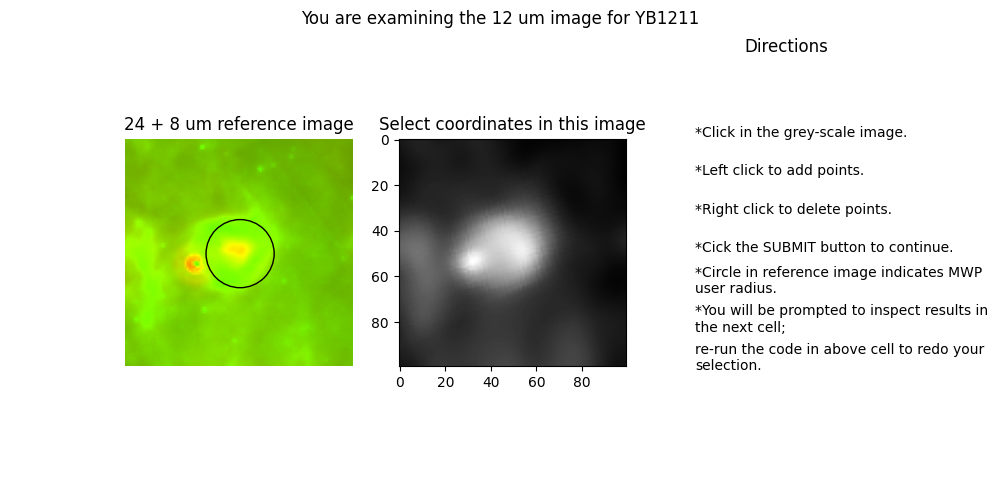

In [96]:
# @title
# need to update all this to have generalization to the um value
#return umselect index for everything

origum=orig[umselect]

if np.isnan(origum.min()) == False and np.isnan(origum.max()) == False:
    #reset global list coords that gets created in get_coords
    coords = []
    #get the coordinates by interacting with image
    get_coords_colab(workmask[umselect], wcsdata[umselect], selectedum, YB)
else:
    print('Image is saturated. Skip to final step to assign results to table')
    coord = ' '
    flag = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Run the cell below to see the mask and background removal results for the points you selected. If you wish to redo your point selection, run the above cell again. If you are satisfied, you can continue on to the next steps.

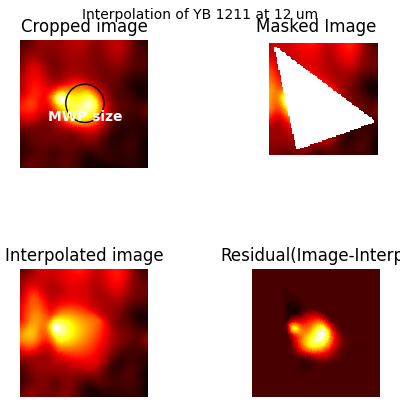

Please consult the residual image. If you wish to redo your selction, re-run the previous cell and select different points.


In [31]:
# @title
#do the masking and interpolation on 70um image
#print('starting interp on coords', coordinates)
coordinates = coords

interp = do_interp(workmask[umselect], coordinates)
diff = interp.resid
#display the images
make_figs(workmask[umselect], interp.blanked, interp.interp,
          interp.resid, images[umselect], wcsdata[umselect], selectedum)

#save the coordinates to write to csv later
coord = str(coordinates)

#Prompt user to accept the selected region or redo
print('Please consult the residual image. If you wish to redo your selction, re-run the previous cell and select different points.')



Once you are satisfied with your mask selection, run the below cell to review the YB and assign any flags.

Output()

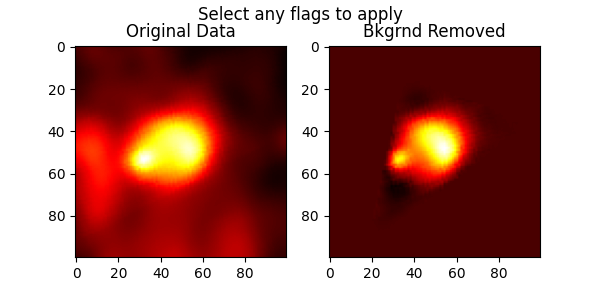

In [32]:
# @title
#%run {libdir}PhotomStartUp.ipynb
#determine the flags
global f1, f2, f3, f4, f5, f6, f7, f8
f1=0
f2=0
f3=0
f4=0
f5=0
f6=0
f7=0
f8=0
out.clear_output()
make_flags(workmask[umselect], interp.resid, selectedum)

Run the below cell to assign the flags you just chose:

In [29]:
# @title
#assign flags
flag = [f1, f2, f3, f4, f5, f6, f7, f8]
#print(flag70)

Run the below cell to write the photometry results and flags out to your csv file. The displayed will help you keep track of your progress.

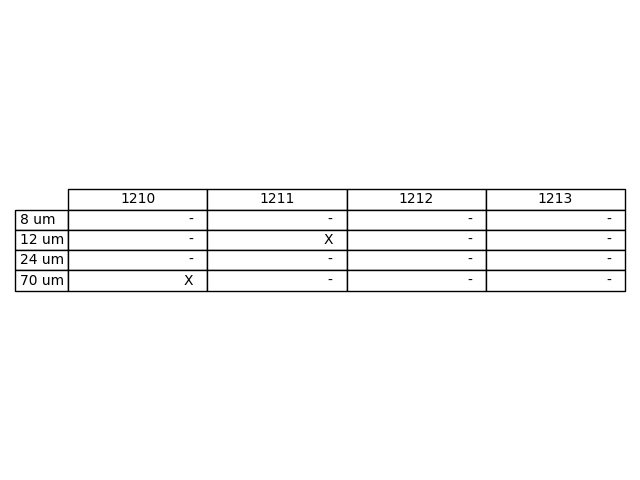

In [28]:
# @title
# Use residual images to perform photometry
#call the get_flux class
fluxval = get_flux_colab(diff, umselect)

#determine with columns get the photometry, flags, and vertices information

if umselect == 0:
    vertices = 'vertices 8'
    photom = '8umphotom'
    flag1 = '8flag1'
    flag2 = '8flag2'
    flag3 = '8flag3'
    flag4 = '8flag4'
    flag5 = '8flag5'
    flag6 = '8flag6'
    flag7 = '8flag7'
    flag8 = '8flag8'
elif umselect == 1:
    vertices = 'vertices 12'
    photom = '12umphotom'
    flag1 = '12flag1'
    flag2 = '12flag2'
    flag3 = '12flag3'
    flag4 = '12flag4'
    flag5 = '12flag5'
    flag6 = '12flag6'
    flag7 = '12flag7'
    flag8 = '12flag8'
elif umselect == 2:
    vertices = 'vertices 24'
    photom = '24umphotom'
    flag1 = '24flag1'
    flag2 = '24flag2'
    flag3 = '24flag3'
    flag4 = '24flag4'
    flag5 = '24flag5'
    flag6 = '24flag6'
    flag7 = '24flag7'
    flag8 = '24flag8'
elif umselect == 3:
    vertices = 'vertices 70'
    photom = '70umphotom'
    flag1 = '70flag1'
    flag2 = '70flag2'
    flag3 = '70flag3'
    flag4 = '70flag4'
    flag5 = '70flag5'
    flag6 = '70flag6'
    flag7 = '70flag7'
    flag8 = '70flag8'
# write out to table with flags
df = pd.read_csv(out_name)

kk = str(YB)

df.loc[df["YB"] == kk, photom] = round(fluxval.flux, 5)

df.loc[df["YB"] == kk, vertices] = coord

df.loc[df["YB"] == kk, flag1 ] = flag[0]
df.loc[df["YB"] == kk, flag2 ] = flag[1]
df.loc[df["YB"] == kk, flag3 ] = flag[2]
df.loc[df["YB"] == kk, flag4 ] = flag[3]
df.loc[df["YB"] == kk, flag5 ] = flag[4]
df.loc[df["YB"] == kk, flag6 ] = flag[5]
df.loc[df["YB"] == kk, flag7 ] = flag[6]
df.loc[df["YB"] == kk, flag8 ] = flag[7]


df.to_csv(out_name, index=False)

#table to track progress
plt.close('all')
figtrack, axtrack = plt.subplots()
figtrack.patch.set_visible(False)
figtrack.canvas.header_visible = False
figtrack.canvas.footer_visible = False
figtrack.canvas.toolbar_visible = False
figtrack.canvas.resizable = False
axtrack.axis('off')
axtrack.axis('tight')

#update data to reflect what was just written out
dftrack.at[selectedum, kk]= 'X'
axtrack.table(cellText=dftrack.values, colLabels=dftrack.columns, rowLabels=dftrack.index, loc='center')
figtrack.tight_layout()
plt.show()
#print(dftrack)


Once the table updates, go back up to the cell under **"This is the iterative part to re-run for each photometric measurement!"** to choose your next YB and/or wavelength to analyze.

--------------------
# **To do**:

1. Add some sort of safety check to make sure that steps were done in order to ensure the proper data is actually being written to table-- right now you could just select the radio buttons and do steps out of order and write wrong data to wrong place.

2. Improve instructions based on feedback

3. Known plotting issues (see 1212 at 70 um) with full range not being plotted - don't know why

4. Double check and make sure projection of images vs. pixel point selection for vertices is all good - will be important for reproducing images after the fact

In [80]:
btn = widgets.Button(description="SUBMIT AND CONTINUE", button_style='danger',
                     width='auto',
                     height='50px',
                     align_items='stretch',
                     display='flex',
                     flex_flow='column',
                     style=dict(font_weight='bold', font_size='18pt'))

box = widgets.HBox(children=[btn])
box.color = 'red'
display(box)

In [86]:
layout = widgets.Layout(width='auto', height='40px', align_items='center') #set width and height

button = widgets.Button(
    description='SUBMIT AND CONTINUE',
    disabled=False,
    display='flex',
    flex_flow='column',
    #align_items='center',
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    style=dict(font_weight='bold'),
    layout = layout
)
display(button)

Button(button_style='danger', description='SUBMIT AND CONTINUE', layout=Layout(align_items='center', height='4…